# Expression analysis in MirGeneDB

In [1]:
import pandas as pd
import numpy as np
import sys
from scipy.stats import ks_2samp, mannwhitneyu
import matplotlib.pyplot as plt

In [2]:
SOURCE = 'mirgenedb'

In [3]:
def extract_df(string, df, handle_col_multiplicity='sum'):
	
	if string != 'all':
		new_df = df.loc[:, df.columns.str.contains(string)]
	else:
		new_df = df.copy()
	
	if handle_col_multiplicity == 'sum':
		new_df = new_df.sum(axis=1)
		new_df = pd.DataFrame(new_df, columns=[f'sum_of_expression_{string}'])
	elif handle_col_multiplicity == 'mean':
		new_df = new_df.mean(axis=1)
		new_df = pd.DataFrame(new_df, columns=[f'mean_of_expression_{string}'])
	else:
		raise ValueError("handle_col_multiplicity must be 'sum' or 'mean'")
	
	return new_df

def filter_idx(lst, df):
	# filter only those rows whose index is in the list
	new_df = df[df.index.isin(lst)]
	return new_df

def compare_expr_boxplot(df1, df2, title1, title2, plot_title, min_y, max_y, jitter=True):
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.boxplot([df1.values.flatten(), df2.values.flatten()], positions=[1, 1.5], showfliers=False, medianprops={'color':'red'})

    # add jittered scatter plots
    if jitter:
        y1 = df1.values.flatten()
        y2 = df2.values.flatten()
        x1 = np.random.normal(1, 0.02, size=len(y1))  # jitter x around position 1
        x2 = np.random.normal(1.5, 0.02, size=len(y2))  # jitter x around position 2
        ax.scatter(x1, y1, color='royalblue', alpha=0.8, s=10)
        ax.scatter(x2, y2, color='orange', alpha=0.8, s=10)

    ax.grid(axis='y')
    ax.set_ylim(min_y, max_y)
    ax.set_xticklabels(['', ''])
    plt.xlim(0.7, 1.8)
    plt.tight_layout()
    plt.savefig(f"../local/pictures/expression/{SOURCE}_{plot_title}_{title1}_{title2}.png", dpi=300)
    plt.show()

    # Stats
    print(f"Data: {plot_title}")
    intro = f"Median value of sum of expression"
    print(f"{intro} {title1}: {round(np.median(df1.values.flatten()), 6)}")
    print(f"{intro} {title2}: {round(np.median(df2.values.flatten()), 6)}")
    print(f"Kolmogorov-Smirnov test:\t{ks_2samp(df1.values.flatten(), df2.values.flatten())}")
    print(f"Mann-Whitney U test:\t\t{mannwhitneyu(df1.values.flatten(), df2.values.flatten())}")

def extract_list(list_of_tuples):
	lst = []
	present = []
	
	for t in list_of_tuples:
	
		if t[0] in present:
			continue
		
		if t[1] in present:
			continue
		
		lst.append(t[0])
		lst.append(t[1])

		present.append(t[0])
		present.append(t[1])

	return lst

def handle_duplicated_rows(df, strategy):

    if strategy not in {'mean', 'max', 'min'}:
        raise ValueError("Strategy must be one of: 'mean', 'max', 'min'")

    return df.groupby(df.index).agg(strategy)

def norm_column(df):
	return df.div(df.sum(axis=0), axis=1)

def all_clades_in_pre2R(mirna):
    clades = mirna_lno_dict.get(mirna, [])
    return all(clade in pre_2R_clades for clade in clades)

___________________________________________

In [4]:
species = 'hsa'
expr_lvl_matr = f'./{species}-tissueItems_clean.tsv'
expr_df = pd.read_csv(expr_lvl_matr, sep='\t', header=0, index_col=0)
expr_df

,DCR-knockout1_hsa_SRR3174967,DCR-knockout2_hsa_SRR3174968,DROSHA-knockout1_hsa_SRR3174962,DROSHA-knockout2_hsa_SRR3174963,XPO-knockout1_hsa_SRR3174965,XPO-knockout2_hsa_SRR3174966,blood_hsa_SRR6880328-31,brain-fetal_hsa_SRR6853295,brain_hsa_SRR6853289,cell-lines-combined_hsa_SRR5127211,...,skeletal-muscle_hsa_SRR6853299,skin-leg_hsa,skin_hsa_SRR330904-23,small-intestine_hsa_SRR6853296,spinal-cord_hsa_SRR6853285,spleen_hsa_SRR6853286,stomach_hsa_SRR6853287,testis_hsa_SRR6853288,thymus_hsa_SRR6853302,uterus_hsa_SRR6853303
Gene name,,,,,,,,,,,,,,,,,,,,,
Hsa-Let-7-P1b,25.32,38.21,160.56,38.73,44.74,69.14,12.24,21377.01,8347.29,2264.64,...,2144.08,1890.85,1470.16,8426.77,1657.14,4098.27,7006.35,2467.99,3764.92,9824.55
Hsa-Let-7-P1c,3.17,0.00,0.00,7.75,0.00,0.00,38.86,29978.07,19552.82,2544.90,...,7815.91,12316.78,19119.36,4358.46,7234.42,419.22,20520.26,13047.86,17901.60,50604.97
Hsa-Let-7-P1d,534.97,559.63,1284.49,906.27,702.03,1029.74,30376.58,15062.74,132742.19,33686.15,...,21528.03,63879.93,129556.86,44043.23,56298.47,33306.59,94562.54,62880.94,62497.72,59270.77
Hsa-Let-7-P2a1,680.59,775.39,1284.49,898.53,702.03,1031.95,30378.22,15076.77,132773.55,33677.45,...,21565.43,63892.73,129612.35,44052.59,56330.93,33292.13,94562.54,62898.41,62522.01,59290.31
Hsa-Let-7-P2a2,658.43,642.79,1284.49,921.77,703.17,1035.63,30384.16,15153.28,133033.74,33682.34,...,21615.29,63989.73,129784.49,44111.87,56424.70,33357.19,94637.94,62924.36,62558.45,59389.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hsa-Mir-96-P1,41.15,38.21,0.00,7.75,274.16,446.47,1002.92,0.00,0.83,78.59,...,0.00,221.62,114.67,12.48,13.52,0.00,0.00,25.42,0.00,0.00
Hsa-Mir-96-P2,4621.66,6169.44,3349.90,2269.56,17842.01,27449.24,12221.27,1.40,17.60,6620.16,...,0.00,453.35,2293.05,71.76,366.95,7.23,69.60,205.97,218.61,0.00
Hsa-Mir-96-P3-v1,13497.77,13116.52,686.04,495.74,777.73,1272.47,5355.71,2.11,5.50,784.95,...,24.93,265.07,597.34,99.84,100.98,14.46,214.60,70.95,534.38,14.22


In [5]:
expr_df_avg = handle_duplicated_rows(expr_df, 'mean')
expr_df_avg

,DCR-knockout1_hsa_SRR3174967,DCR-knockout2_hsa_SRR3174968,DROSHA-knockout1_hsa_SRR3174962,DROSHA-knockout2_hsa_SRR3174963,XPO-knockout1_hsa_SRR3174965,XPO-knockout2_hsa_SRR3174966,blood_hsa_SRR6880328-31,brain-fetal_hsa_SRR6853295,brain_hsa_SRR6853289,cell-lines-combined_hsa_SRR5127211,...,skeletal-muscle_hsa_SRR6853299,skin-leg_hsa,skin_hsa_SRR330904-23,small-intestine_hsa_SRR6853296,spinal-cord_hsa_SRR6853285,spleen_hsa_SRR6853286,stomach_hsa_SRR6853287,testis_hsa_SRR6853288,thymus_hsa_SRR6853302,uterus_hsa_SRR6853303
Gene name,,,,,,,,,,,,,,,,,,,,,
Hsa-Let-7-P1b,25.32,38.21,160.56,38.73,44.74,69.14,12.24,21377.01,8347.29,2264.64,...,2144.08,1890.85,1470.16,8426.77,1657.14,4098.27,7006.35,2467.99,3764.92,9824.55
Hsa-Let-7-P1c,3.17,0.00,0.00,7.75,0.00,0.00,38.86,29978.07,19552.82,2544.90,...,7815.91,12316.78,19119.36,4358.46,7234.42,419.22,20520.26,13047.86,17901.60,50604.97
Hsa-Let-7-P1d,534.97,559.63,1284.49,906.27,702.03,1029.74,30376.58,15062.74,132742.19,33686.15,...,21528.03,63879.93,129556.86,44043.23,56298.47,33306.59,94562.54,62880.94,62497.72,59270.77
Hsa-Let-7-P2a1,680.59,775.39,1284.49,898.53,702.03,1031.95,30378.22,15076.77,132773.55,33677.45,...,21565.43,63892.73,129612.35,44052.59,56330.93,33292.13,94562.54,62898.41,62522.01,59290.31
Hsa-Let-7-P2a2,658.43,642.79,1284.49,921.77,703.17,1035.63,30384.16,15153.28,133033.74,33682.34,...,21615.29,63989.73,129784.49,44111.87,56424.70,33357.19,94637.94,62924.36,62558.45,59389.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hsa-Mir-96-P1,41.15,38.21,0.00,7.75,274.16,446.47,1002.92,0.00,0.83,78.59,...,0.00,221.62,114.67,12.48,13.52,0.00,0.00,25.42,0.00,0.00
Hsa-Mir-96-P2,4621.66,6169.44,3349.90,2269.56,17842.01,27449.24,12221.27,1.40,17.60,6620.16,...,0.00,453.35,2293.05,71.76,366.95,7.23,69.60,205.97,218.61,0.00
Hsa-Mir-96-P3-v1,13497.77,13116.52,686.04,495.74,777.73,1272.47,5355.71,2.11,5.50,784.95,...,24.93,265.07,597.34,99.84,100.98,14.46,214.60,70.95,534.38,14.22


In [6]:
expr_df_avg_norm = norm_column(expr_df_avg)
expr_df_avg_norm

,DCR-knockout1_hsa_SRR3174967,DCR-knockout2_hsa_SRR3174968,DROSHA-knockout1_hsa_SRR3174962,DROSHA-knockout2_hsa_SRR3174963,XPO-knockout1_hsa_SRR3174965,XPO-knockout2_hsa_SRR3174966,blood_hsa_SRR6880328-31,brain-fetal_hsa_SRR6853295,brain_hsa_SRR6853289,cell-lines-combined_hsa_SRR5127211,...,skeletal-muscle_hsa_SRR6853299,skin-leg_hsa,skin_hsa_SRR330904-23,small-intestine_hsa_SRR6853296,spinal-cord_hsa_SRR6853285,spleen_hsa_SRR6853286,stomach_hsa_SRR6853287,testis_hsa_SRR6853288,thymus_hsa_SRR6853302,uterus_hsa_SRR6853303
Gene name,,,,,,,,,,,,,,,,,,,,,
Hsa-Let-7-P1b,0.000023,0.000036,0.000181,0.000043,0.000043,0.000066,0.000012,0.020876,5.513656e-03,0.001842,...,0.004168,0.001570,0.001131,0.008258,0.001189,0.003786,0.006440,0.001740,0.002972,0.009878
Hsa-Let-7-P1c,0.000003,0.000000,0.000000,0.000009,0.000000,0.000000,0.000037,0.029275,1.291527e-02,0.002070,...,0.015193,0.010225,0.014712,0.004271,0.005192,0.000387,0.018862,0.009198,0.014133,0.050881
Hsa-Let-7-P1d,0.000477,0.000521,0.001451,0.001003,0.000682,0.000980,0.029028,0.014709,8.768053e-02,0.027406,...,0.041848,0.053032,0.099688,0.043161,0.040402,0.030771,0.086919,0.044326,0.049340,0.059594
Hsa-Let-7-P2a1,0.000607,0.000722,0.001451,0.000995,0.000682,0.000982,0.029030,0.014723,8.770125e-02,0.027399,...,0.041921,0.053043,0.099731,0.043170,0.040425,0.030758,0.086919,0.044339,0.049359,0.059614
Hsa-Let-7-P2a2,0.000587,0.000599,0.001451,0.001020,0.000683,0.000985,0.029036,0.014798,8.787311e-02,0.027403,...,0.042018,0.053123,0.099864,0.043228,0.040493,0.030818,0.086988,0.044357,0.049388,0.059714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hsa-Mir-96-P1,0.000037,0.000036,0.000000,0.000009,0.000266,0.000425,0.000958,0.000000,5.482420e-07,0.000064,...,0.000000,0.000184,0.000088,0.000012,0.000010,0.000000,0.000000,0.000018,0.000000,0.000000
Hsa-Mir-96-P2,0.004123,0.005748,0.003783,0.002512,0.017327,0.026119,0.011679,0.000001,1.162537e-05,0.005386,...,0.000000,0.000376,0.001764,0.000070,0.000263,0.000007,0.000064,0.000145,0.000173,0.000000
Hsa-Mir-96-P3-v1,0.012041,0.012220,0.000775,0.000549,0.000755,0.001211,0.005118,0.000002,3.632929e-06,0.000639,...,0.000048,0.000220,0.000460,0.000098,0.000072,0.000013,0.000197,0.000050,0.000422,0.000014


_________________________

In [7]:
df_to_use = expr_df_avg_norm
df_to_use

df_to_use = df_to_use.apply(pd.to_numeric, errors='coerce').fillna(0)
df_to_use = df_to_use[df_to_use.sum(axis=1) > 0]

df_to_use = df_to_use.astype(float)

______________________

## Parse duplicate miRNAs

In [8]:
mirna_origin_file_path = '../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirna_origin = df_mirna_origin[[0, 14, 15]]
df_mirna_origin = df_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirna_origin.columns = cols
df_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

print("Test on 'Hsa-Let-7-P1d': ", mirna_lno_dict['Hsa-Let-7-P1d'][0])

pre_2R_clades = ['Bilateria', 
                'Chordata', 
                'Eumetazoa', 
                'Vertebrata', 
                'Nephrozoa', 
                'Olphactores']

Test on 'Hsa-Let-7-P1d':  Bilateria


In [9]:
om_pairs_path = f'../Motif_analysis/PPI_Bifan/ohnomirna_pairs_predict_Hsa_existent.names.extended_info.flagged_WGD_host_genes.tsv'
pm_pairs_path = f'../3_retrieve_Hsa_paralogs/mgdb_3_hsa.premirna_paralog_pairs.extended_info.tsv'

om_pairs_df = pd.read_csv(om_pairs_path, sep='\t', header=0)
pm_pairs_df = pd.read_csv(pm_pairs_path, sep='\t', header=None)

print("Number of pairs BEFORE 2R filtering:", pm_pairs_df.shape[0])

pm_pairs_pre2R_df = pm_pairs_df[~pm_pairs_df[0].apply(all_clades_in_pre2R) | ~pm_pairs_df[1].apply(all_clades_in_pre2R)]
pm_pairs_post2R_df = pm_pairs_df[pm_pairs_df[0].apply(all_clades_in_pre2R) & pm_pairs_df[1].apply(all_clades_in_pre2R)]

print("Number of pairs AFTER 2R filtering:", pm_pairs_pre2R_df.shape[0], "\npost2R pairs:", pm_pairs_post2R_df.shape[0])

om_pairs_intragenic_df = om_pairs_df[~om_pairs_df['host_gene_name_1'].isin(['intergenic']) & ~om_pairs_df['host_gene_name_2'].isin(['intergenic'])]
om_pairs_intergenic_df = om_pairs_df[om_pairs_df['host_gene_name_1'].isin(['intergenic']) | om_pairs_df['host_gene_name_2'].isin(['intergenic'])]

Number of pairs BEFORE 2R filtering: 2655
Number of pairs AFTER 2R filtering: 879 
post2R pairs: 1776


In [10]:
om_pairs = om_pairs_df.iloc[:, [0, 7]].values
om_pairs = [tuple(sorted(pair)) for pair in om_pairs]
om_pairs = list(set(om_pairs))
print(f"Number of om pairs: {len(om_pairs)}", file=sys.stderr)

om_pairs_intragenic = om_pairs_intragenic_df.iloc[:, [0, 7]].values
om_pairs_intragenic = [tuple(sorted(pair)) for pair in om_pairs_intragenic]
om_pairs_intragenic = list(set(om_pairs_intragenic))
print(f"Number of om pairs intragenic: {len(om_pairs_intragenic)}", file=sys.stderr)

om_pairs_intergenic = om_pairs_intergenic_df.iloc[:, [0, 7]].values
om_pairs_intergenic = [tuple(sorted(pair)) for pair in om_pairs_intergenic]
om_pairs_intergenic = list(set(om_pairs_intergenic))
print(f"Number of om pairs intergenic: {len(om_pairs_intergenic)}", file=sys.stderr)

print(100*"=", file=sys.stderr)

pm_pairs = pm_pairs_df.iloc[:, [0, 5]].values
pm_pairs = [tuple(sorted(pair)) for pair in pm_pairs]
pm_pairs = list(set(pm_pairs))
print(f"Number of pm pairs: {len(pm_pairs)}", file=sys.stderr)

pm_pairs_pre2R = pm_pairs_pre2R_df.iloc[:, [0, 5]].values
pm_pairs_pre2R = [tuple(sorted(pair)) for pair in pm_pairs_pre2R]
pm_pairs_pre2R = list(set(pm_pairs_pre2R))
print(f"Number of pre2R pm pairs: {len(pm_pairs_pre2R)}", file=sys.stderr)

pm_pairs_pre2R = [pair for pair in pm_pairs_pre2R if pair not in om_pairs]
print(f"Number of pre2R pm pairs after filtering out om pairs: {len(pm_pairs_pre2R)}", file=sys.stderr)

pm_pairs_post2R = pm_pairs_post2R_df.iloc[:, [0, 5]].values
pm_pairs_post2R = [tuple(sorted(pair)) for pair in pm_pairs_post2R]
pm_pairs_post2R = list(set(pm_pairs_post2R))
print(f"Number of post2R pm pairs: {len(pm_pairs_post2R)}", file=sys.stderr)

pm_pairs_post2R = [pair for pair in pm_pairs_post2R if pair not in om_pairs]
print(f"Number of post2R pm pairs post2R after filtering out om pairs: {len(pm_pairs_post2R)}", file=sys.stderr)

Number of om pairs: 114
Number of om pairs intragenic: 25
Number of om pairs intergenic: 89
Number of pm pairs: 2467
Number of pre2R pm pairs: 798
Number of pre2R pm pairs after filtering out om pairs: 783
Number of post2R pm pairs: 1669
Number of post2R pm pairs post2R after filtering out om pairs: 1570


In [11]:
om_list = extract_list(om_pairs)
pm_list = extract_list(pm_pairs)
om_list_intragenic = extract_list(om_pairs_intragenic)
om_list_intergenic = extract_list(om_pairs_intergenic)
pm_list_pre2R = extract_list(pm_pairs_pre2R)
pm_list_post2R = extract_list(pm_pairs_post2R)

# remove prom pm_list those that are in om_list
pm_list_pre2R = [m for m in pm_list_pre2R if m not in om_list]
pm_list_post2R = [m for m in pm_list_post2R if m not in om_list]
pm_list = [m for m in pm_list if m not in om_list]

for lst,l in [(om_list, 'om'), (om_list_intragenic, 'intragenic om'), (om_list_intergenic, 'intergenic om')]:
	print(f"Number of unique {l} elements: {len(lst)}", file=sys.stderr)

print(100*"=", file=sys.stderr)

for lst,l in [(pm_list, 'pm'), (pm_list_pre2R, 'pre-2R pm'), (pm_list_post2R, 'post-2R pm')]:
	print(f"Number of unique {l} elements: {len(lst)}", file=sys.stderr)


Number of unique om elements: 112
Number of unique intragenic om elements: 34
Number of unique intergenic om elements: 88
Number of unique pm elements: 172
Number of unique pre-2R pm elements: 80
Number of unique post-2R pm elements: 93


In [12]:
# extract a list of miRNAs that contains the string "Mir-430" (check both in om and pm)
om_list_mir430 = [m for m in om_list if 'Mir-430' in m]
pm_list_mir430 = [m for m in pm_list if 'Mir-430' in m]
mir430 = list(set(om_list_mir430).union(pm_list_mir430))

mir430

['Hsa-Mir-430-P38',
 'Hsa-Mir-430-P19',
 'Hsa-Mir-430-P23',
 'Hsa-Mir-430-P11',
 'Hsa-Mir-430-P9',
 'Hsa-Mir-430-P41b',
 'Hsa-Mir-430-P40a',
 'Hsa-Mir-430-P37c',
 'Hsa-Mir-430-P6',
 'Hsa-Mir-430-P2',
 'Hsa-Mir-430-P25',
 'Hsa-Mir-430-P8b',
 'Hsa-Mir-430-P17',
 'Hsa-Mir-430-P39',
 'Hsa-Mir-430-P12b',
 'Hsa-Mir-430-P37a',
 'Hsa-Mir-430-P22',
 'Hsa-Mir-430-P7',
 'Hsa-Mir-430-P34b',
 'Hsa-Mir-430-P3',
 'Hsa-Mir-430-P13',
 'Hsa-Mir-430-P29b',
 'Hsa-Mir-430-P27',
 'Hsa-Mir-430-P37b',
 'Hsa-Mir-430-P5',
 'Hsa-Mir-430-P12a',
 'Hsa-Mir-430-P32',
 'Hsa-Mir-430-P34a',
 'Hsa-Mir-430-P10',
 'Hsa-Mir-430-P4',
 'Hsa-Mir-430-P28',
 'Hsa-Mir-430-P35',
 'Hsa-Mir-430-P24',
 'Hsa-Mir-430-P31a',
 'Hsa-Mir-430-P20',
 'Hsa-Mir-430-P33b',
 'Hsa-Mir-430-P41a',
 'Hsa-Mir-430-P1',
 'Hsa-Mir-430-P29c',
 'Hsa-Mir-430-P15',
 'Hsa-Mir-430-P36',
 'Hsa-Mir-430-P26',
 'Hsa-Mir-430-P21',
 'Hsa-Mir-430-P16a',
 'Hsa-Mir-430-P18',
 'Hsa-Mir-430-P8a',
 'Hsa-Mir-430-P40b',
 'Hsa-Mir-430-P30',
 'Hsa-Mir-430-P29a',
 'Hsa-Mir-4

In [13]:
df_o = filter_idx(om_list, df_to_use)
df_p = filter_idx(pm_list, df_to_use)

print(f"Number of om miRNAs: {len(df_o)}")
print(f"Number of pm miRNAs: {len(df_p)}")

Number of om miRNAs: 100
Number of pm miRNAs: 161


In [14]:
df_430 = filter_idx(mir430, df_to_use)
print(f"Number of miRNAs in mir430: {len(df_430)}")

Number of miRNAs in mir430: 52


In [15]:
df_pm_pre2R = filter_idx(pm_list_pre2R, df_to_use)
print(f"Number of pm miRNAs pre2R: {len(df_pm_pre2R)}")

df_pm_post2R = filter_idx(pm_list_post2R, df_to_use)
print(f"Number of pm miRNAs post2R: {len(df_pm_post2R)}")

Number of pm miRNAs pre2R: 73
Number of pm miRNAs post2R: 90


________________________________

## WGD-SSD expression comparison

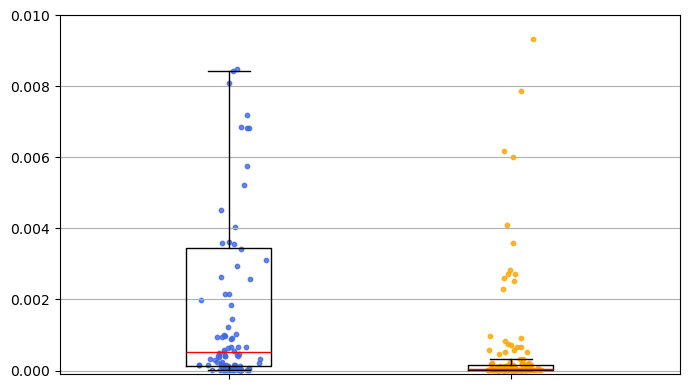

Data: all
Median value of sum of expression WGD: 0.000511
Median value of sum of expression SSD: 3e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4939751552795031, pvalue=3.173217263032125e-14, statistic_location=0.00014332728775203455, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=12293.0, pvalue=8.326250983556314e-13)


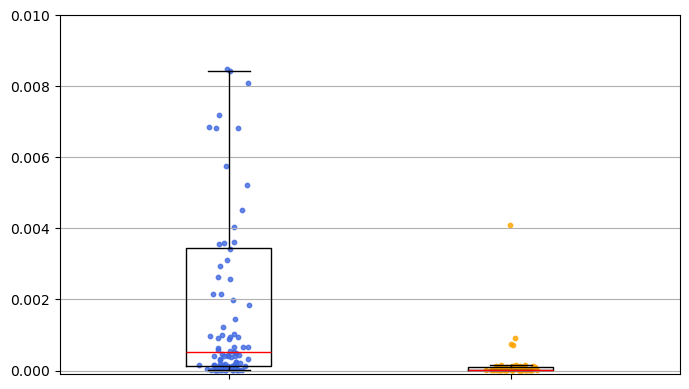

Data: all
Median value of sum of expression WGD: 0.000511
Median value of sum of expression SSD (pre 2R): 2.7e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.6615068493150685, pvalue=4.6199134536246345e-18, statistic_location=0.00014226854587774288, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6010.0, pvalue=4.096234805083345e-13)


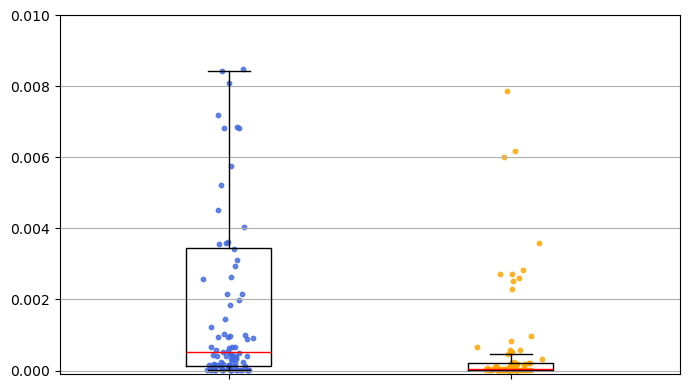

Data: all
Median value of sum of expression WGD: 0.000511
Median value of sum of expression SSD (post 2R): 3.6e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.43555555555555553, pvalue=1.3070662852937112e-08, statistic_location=0.00011421314090879994, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6634.0, pvalue=1.7304115669936908e-08)


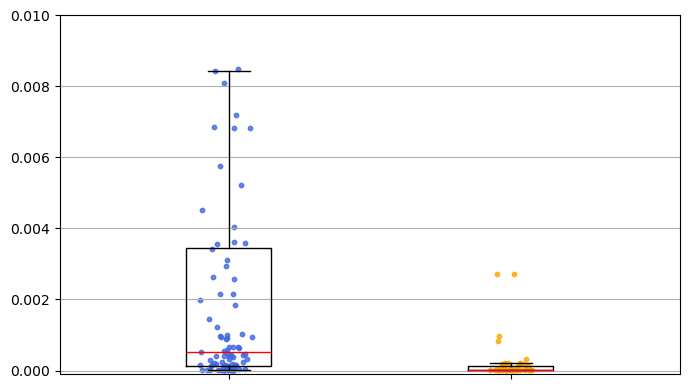

Data: all
Median value of sum of expression WGD: 0.000511
Median value of sum of expression SSD (Mir-430): 2.2e-05
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5538461538461539, pvalue=3.2108261607822683e-10, statistic_location=0.00020306044793721268, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=4253.0, pvalue=1.3821280637158187e-10)


In [16]:
label = 'all'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.0001, 0.01)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.0001, 0.01)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.0001, 0.01)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.0001, 0.01)

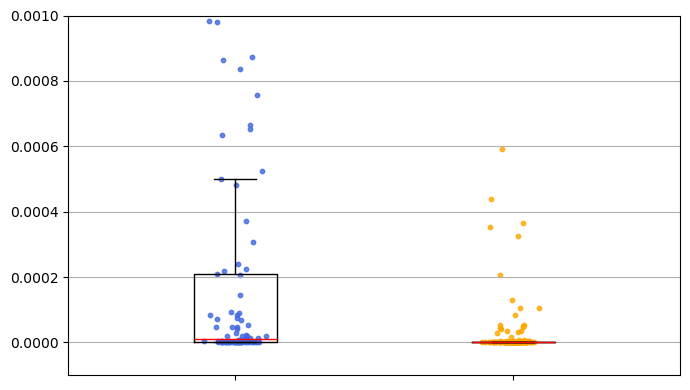

Data: DCR
Median value of sum of expression WGD: 1e-05
Median value of sum of expression SSD: 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.48049689440993787, pvalue=1.8715623948165697e-13, statistic_location=0.0, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=12142.0, pvalue=6.162861693890366e-14)


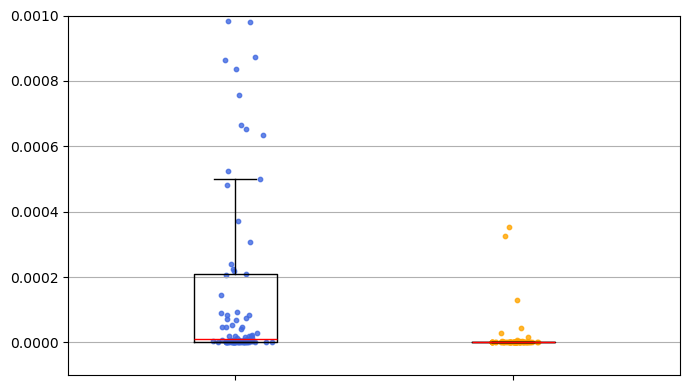

Data: DCR
Median value of sum of expression WGD: 1e-05
Median value of sum of expression SSD (pre 2R): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5282191780821918, pvalue=2.551745551014979e-11, statistic_location=1.048113584208869e-06, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5834.0, pvalue=1.711901773288553e-12)


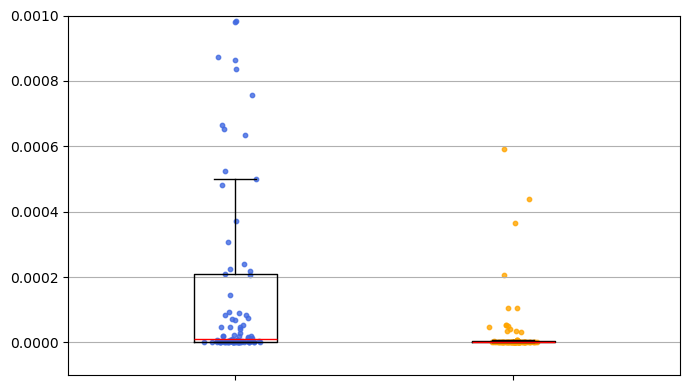

Data: DCR
Median value of sum of expression WGD: 1e-05
Median value of sum of expression SSD (post 2R): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4822222222222222, pvalue=1.6005381522472165e-10, statistic_location=0.0, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6593.5, pvalue=5.275450131788666e-09)


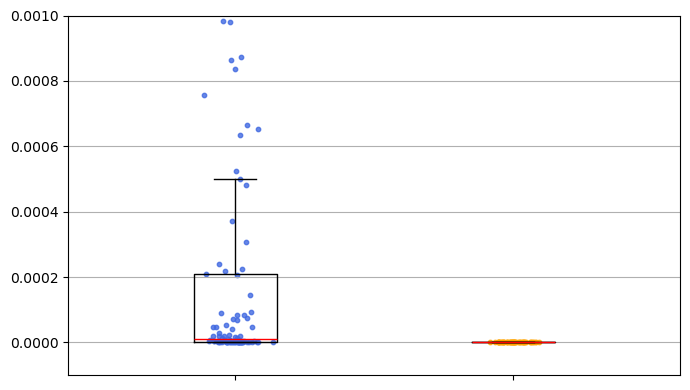

Data: DCR
Median value of sum of expression WGD: 1e-05
Median value of sum of expression SSD (Mir-430): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.76, pvalue=5.090337826893582e-20, statistic_location=0.0, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=4576.0, pvalue=2.362440099697139e-16)


In [17]:
label = 'DCR'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.0001, 0.001)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.0001, 0.001)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.0001, 0.001)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.0001, 0.001)

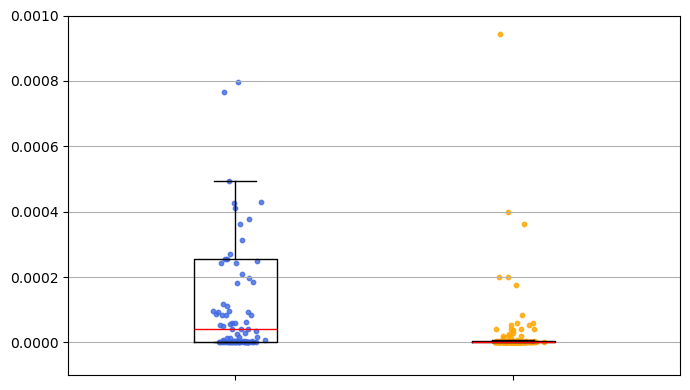

Data: DROSHA
Median value of sum of expression WGD: 4.2e-05
Median value of sum of expression SSD: 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4391304347826087, pvalue=3.058542658930369e-11, statistic_location=0.0, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=11800.0, pvalue=2.381354261483701e-12)


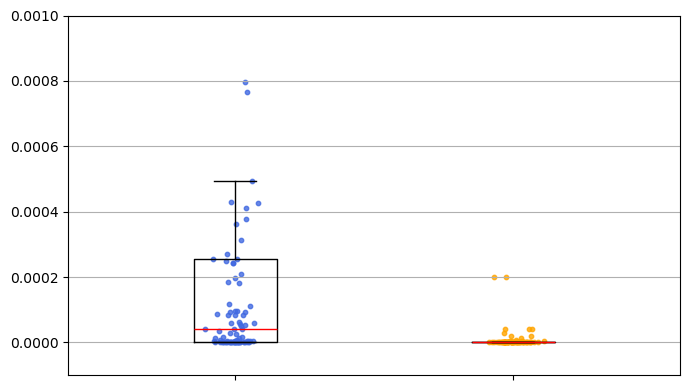

Data: DROSHA
Median value of sum of expression WGD: 4.2e-05
Median value of sum of expression SSD (pre 2R): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4945205479452055, pvalue=6.398520241182887e-10, statistic_location=0.0, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5616.5, pvalue=8.8794330454199e-11)


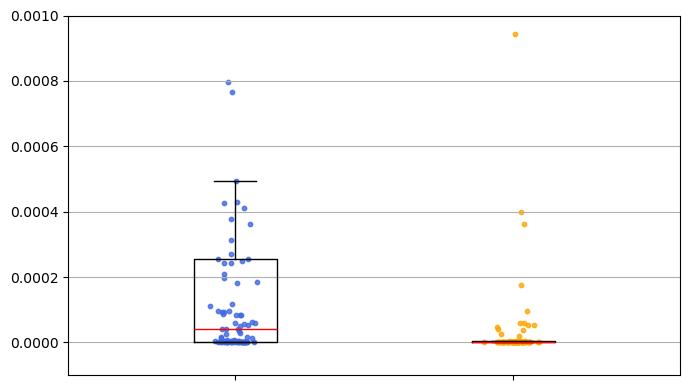

Data: DROSHA
Median value of sum of expression WGD: 4.2e-05
Median value of sum of expression SSD (post 2R): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4222222222222222, pvalue=4.1846880225452303e-08, statistic_location=0.0, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6440.0, pvalue=4.288725438894492e-08)


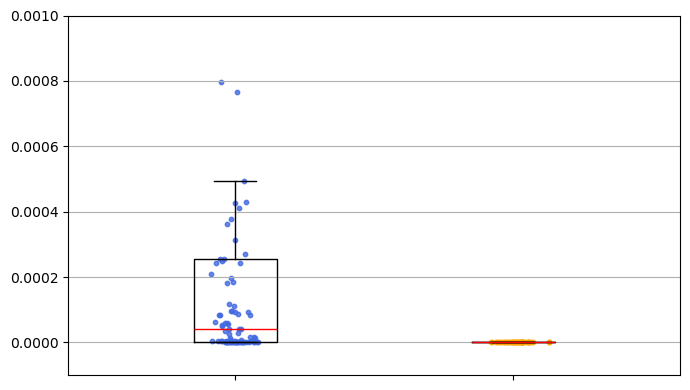

Data: DROSHA
Median value of sum of expression WGD: 4.2e-05
Median value of sum of expression SSD (Mir-430): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.7, pvalue=9.906068472966241e-17, statistic_location=0.0, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=4420.0, pvalue=1.398187483825656e-14)


In [18]:
label = 'DROSHA'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.0001, 0.001)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.0001, 0.001)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.0001, 0.001)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.0001, 0.001)

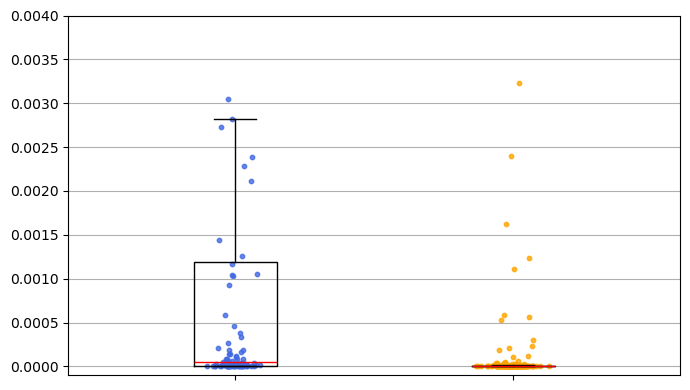

Data: stomach
Median value of sum of expression WGD: 4.8e-05
Median value of sum of expression SSD: 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.502919254658385, pvalue=9.417152090612476e-15, statistic_location=0.0, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=12317.0, pvalue=4.435040646474709e-15)


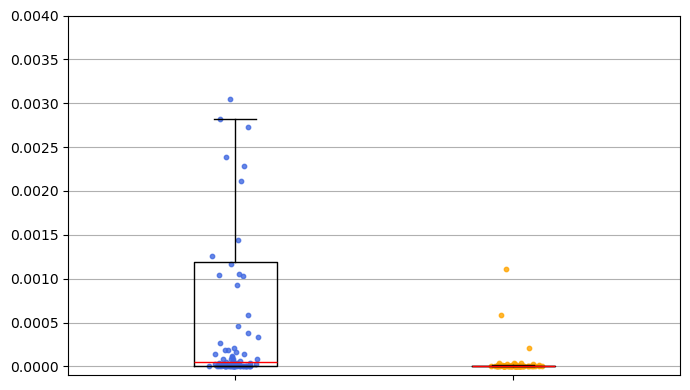

Data: stomach
Median value of sum of expression WGD: 4.8e-05
Median value of sum of expression SSD (pre 2R): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.49602739726027395, pvalue=5.506707541073737e-10, statistic_location=0.0, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5797.0, pvalue=5.22473680793764e-12)


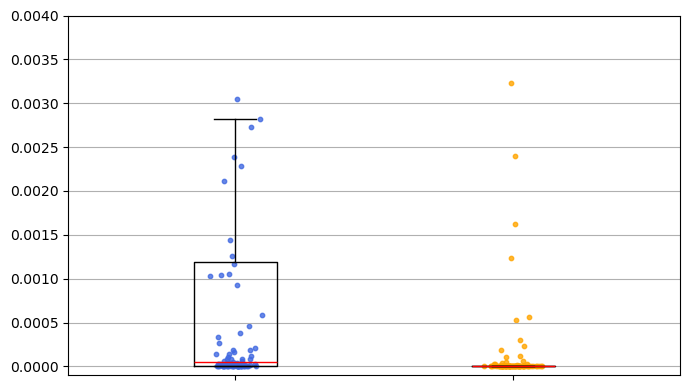

Data: stomach
Median value of sum of expression WGD: 4.8e-05
Median value of sum of expression SSD (post 2R): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5255555555555556, pvalue=1.6624948274287064e-12, statistic_location=0.0, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6835.0, pvalue=6.220609842829186e-11)


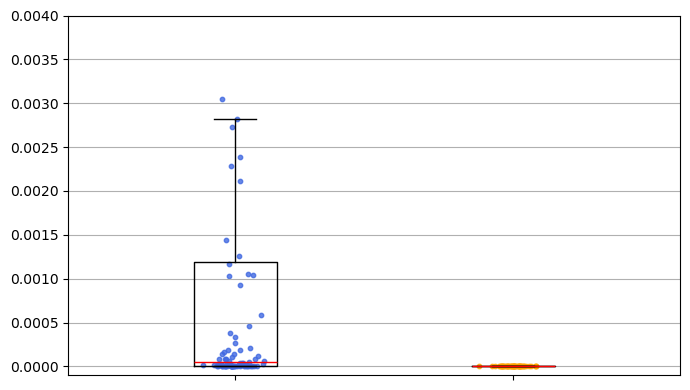

Data: stomach
Median value of sum of expression WGD: 4.8e-05
Median value of sum of expression SSD (Mir-430): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.77, pvalue=1.295114257199597e-20, statistic_location=0.0, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=4602.0, pvalue=1.1498850893814803e-16)


In [19]:
label = 'stomach'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.0001, 0.004)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.0001, 0.004)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.0001, 0.004)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.0001, 0.004)

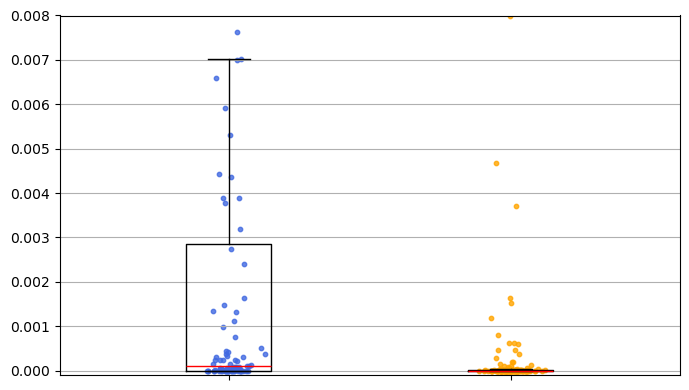

Data: spleen
Median value of sum of expression WGD: 0.000114
Median value of sum of expression SSD: 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4574534161490683, pvalue=3.3514927183214688e-12, statistic_location=2.6709542365112885e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=11804.0, pvalue=1.067330510163122e-11)


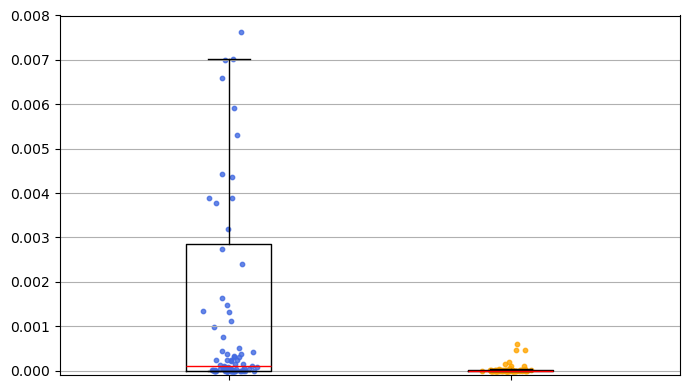

Data: spleen
Median value of sum of expression WGD: 0.000114
Median value of sum of expression SSD (pre 2R): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.48561643835616436, pvalue=1.4235245022316488e-09, statistic_location=2.6709542365112885e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5425.5, pvalue=1.553469208755869e-08)


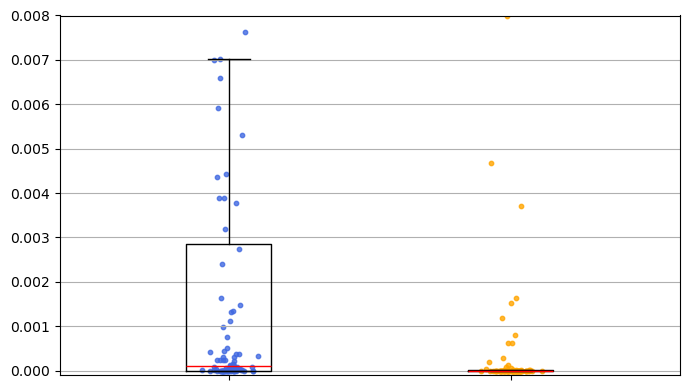

Data: spleen
Median value of sum of expression WGD: 0.000114
Median value of sum of expression SSD (post 2R): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4677777777777778, pvalue=6.611522551466191e-10, statistic_location=6.679695306114361e-06, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6665.0, pvalue=1.0580911208434474e-09)


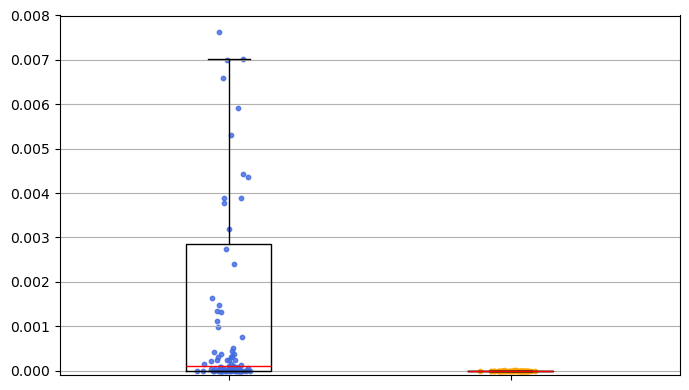

Data: spleen
Median value of sum of expression WGD: 0.000114
Median value of sum of expression SSD (Mir-430): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.69, pvalue=3.17927036841969e-16, statistic_location=6.679695306114361e-06, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=4399.5, pvalue=5.776762613026917e-14)


In [20]:
label = 'spleen'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.0001, 0.008)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.0001, 0.008)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.0001, 0.008)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.0001, 0.008)

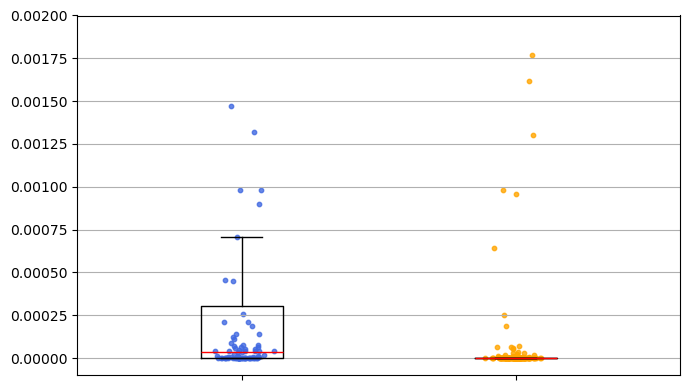

Data: blood
Median value of sum of expression WGD: 3.8e-05
Median value of sum of expression SSD: 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4453416149068323, pvalue=1.471909474894157e-11, statistic_location=6.689312410068764e-07, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=12172.5, pvalue=7.123007624836362e-13)


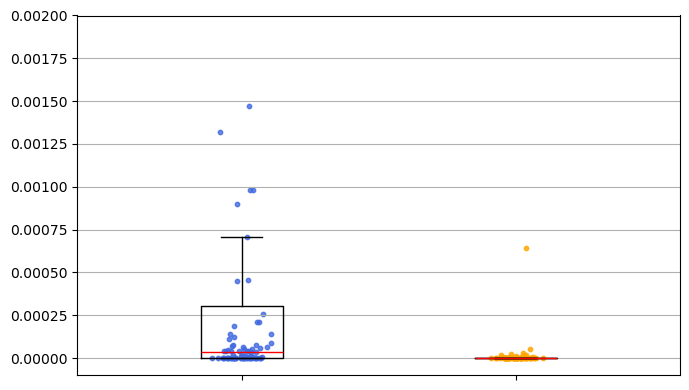

Data: blood
Median value of sum of expression WGD: 3.8e-05
Median value of sum of expression SSD (pre 2R): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4867123287671233, pvalue=1.2731252523488435e-09, statistic_location=5.580797782114512e-06, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5574.5, pvalue=2.460517552733508e-09)


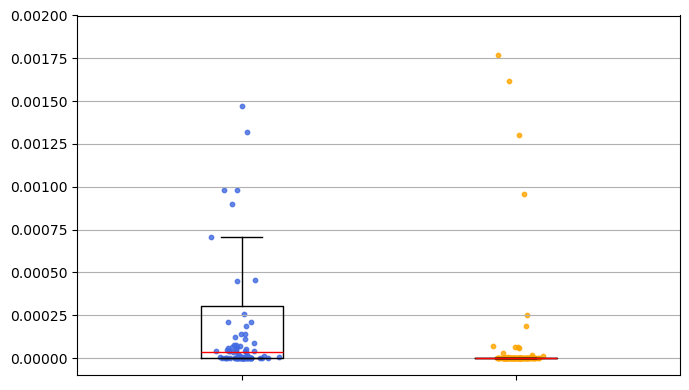

Data: blood
Median value of sum of expression WGD: 3.8e-05
Median value of sum of expression SSD (post 2R): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.5244444444444445, pvalue=1.8802727773885644e-12, statistic_location=1.1467392702975024e-07, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6918.0, pvalue=3.576997790765738e-11)


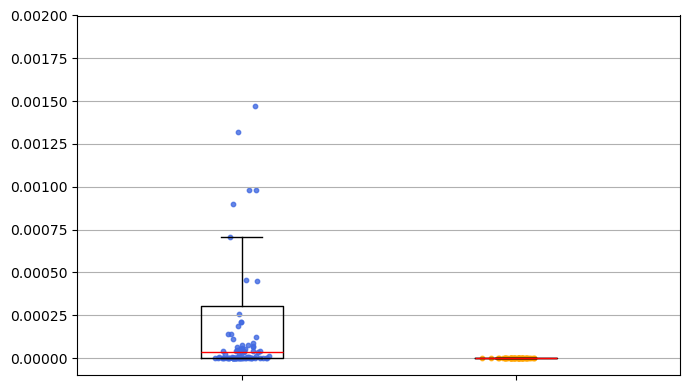

Data: blood
Median value of sum of expression WGD: 3.8e-05
Median value of sum of expression SSD (Mir-430): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.83, pvalue=1.6446815050295553e-24, statistic_location=0.0, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=4758.0, pvalue=1.3583083289019983e-18)


In [21]:
label = 'blood'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.0001, 0.002)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.0001, 0.002)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.0001, 0.002)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.0001, 0.002)

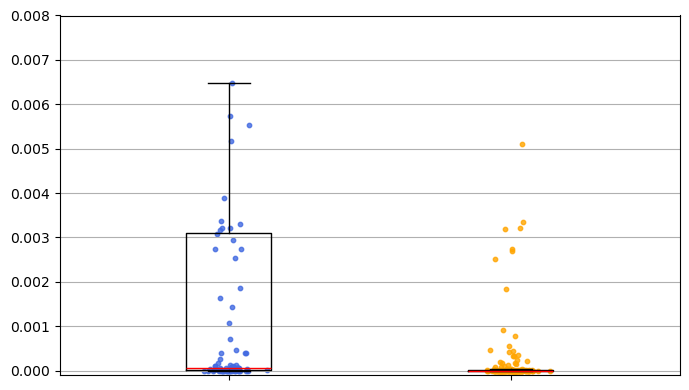

Data: brain
Median value of sum of expression WGD: 6.8e-05
Median value of sum of expression SSD: 1e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.42428571428571427, pvalue=1.6748408097654824e-10, statistic_location=1.2021514025254943e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=11699.0, pvalue=6.576371745060515e-10)


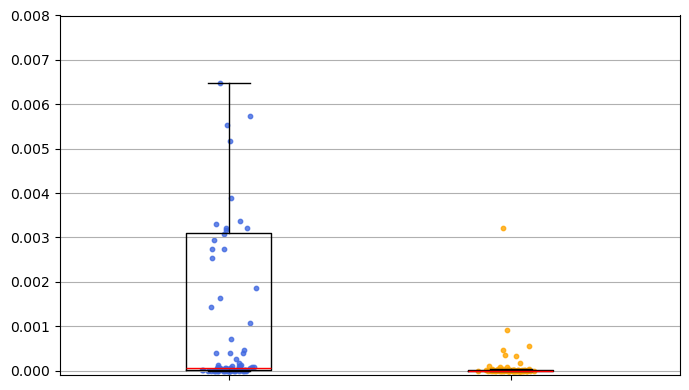

Data: brain
Median value of sum of expression WGD: 6.8e-05
Median value of sum of expression SSD (pre 2R): 3e-06
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4371232876712329, pvalue=8.691277644849732e-08, statistic_location=1.733977703687134e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=5325.5, pvalue=2.541205956260886e-07)


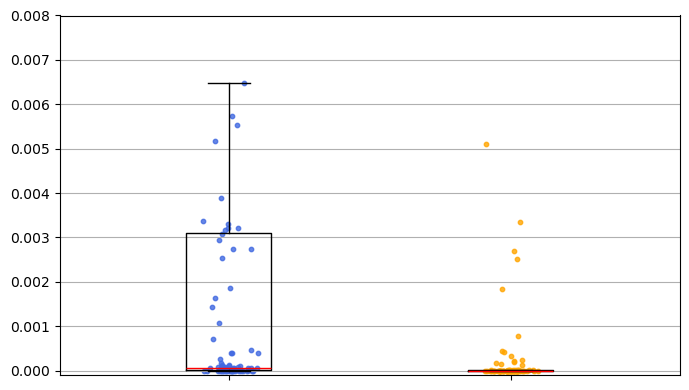

Data: brain
Median value of sum of expression WGD: 6.8e-05
Median value of sum of expression SSD (post 2R): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.4988888888888889, pvalue=2.92251918042734e-11, statistic_location=1.1874810932290043e-05, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=6795.0, pvalue=1.1208111464339908e-09)


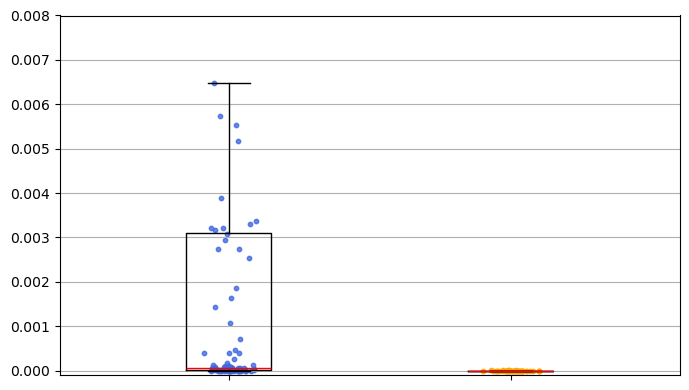

Data: brain
Median value of sum of expression WGD: 6.8e-05
Median value of sum of expression SSD (Mir-430): 0.0
Kolmogorov-Smirnov test:	KstestResult(statistic=0.71, pvalue=3.0084971476876987e-17, statistic_location=9.039316491317462e-06, statistic_sign=-1)
Mann-Whitney U test:		MannwhitneyuResult(statistic=4547.0, pvalue=3.208770995651954e-14)


In [22]:
label = 'brain'
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_p, handle_col_multiplicity='mean'), 'WGD', 'SSD', f'{label}', -0.0001, 0.008)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_pre2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (pre 2R)', f'{label}', -0.0001, 0.008)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_pm_post2R, handle_col_multiplicity='mean'), 'WGD', 'SSD (post 2R)', f'{label}', -0.0001, 0.008)
compare_expr_boxplot(extract_df(label, df_o, handle_col_multiplicity='mean'), extract_df(label, df_430, handle_col_multiplicity='mean'), 'WGD', 'SSD (Mir-430)', f'{label}', -0.0001, 0.008)